TOLERANCIA =  3e-06


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.


pas 1  error =  0.1970030207087552
pas 2  error =  0.021948251730376758
pas 3  error =  0.014587396635491632
pas 4  error =  0.0023248576850760793
pas 5  error =  0.0012384886388748617
pas 6  error =  0.00035476062330590176
pas 7  error =  0.0002272953466471089
pas 8  error =  0.00013874667504036662
pas 9  error =  8.97685712544699e-05
pas 10  error =  5.7383365202594e-05
pas 11  error =  4.115425196261102e-05
pas 12  error =  2.8471101054060718e-05
pas 13  error =  1.8654822188462e-05
pas 14  error =  1.180825285785961e-05
pas 15  error =  7.840490193114588e-06
pas 16  error =  5.05900954204326e-06
pas 17  error =  3.5147648180343585e-06
pas 18  error =  2.488432173684885e-06
[2.82654850e-15 2.86778860e-09 5.09219114e-09 ... 6.88335599e-14
 1.42636940e-14 2.82654850e-15]


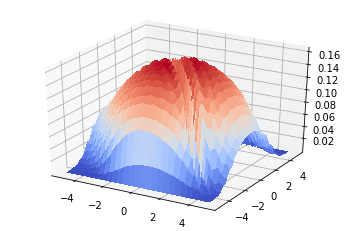

In [4]:
######### BESP 2D #########

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy.optimize
import scipy.sparse.linalg
from scipy.fftpack import fft, ifft
from krypy.linsys import LinearSystem, Gmres

np.set_printoptions(precision=8) # fer que numpy nomes faci print de 3 digits significatius
pi = np.pi

############ Dades input ############

lx = 10 # llargada eix X
ly = 10 # llargada eix Y


# J,K,L han de ser parells
J = 50 # punts eix X
K = 50 # punts eix Y


beta = 500
sigma = 0.0 # Velocitat angular
dt = 0.3 # pas numèric
eps = 1e-5 # Marge d'error càlcul numèric
itmax = 100000 #nombre màxim iteracions



POTENCIAL = 0 #0 - Harmònic

# paràmetres potencial harmònic
gammax = 1
gammay = 1


############ Auxiliars ############

dim1 = J+K
dim2 = J*K
dim3 = (J+1)*(K+1)
dx = lx/(J) 
dy = ly/(K)

ax = lx/2
ay = ly/2

xj = np.arange(-ax,ax+dx,dx)
yk = np.arange(-ay,ay+dy,dy)

jj = np.arange(-J/2,J/2)
kk = np.arange(-K/2,K/2)

mux = pi*jj/lx
muy = pi*kk/ly

a = np.arange(0,J)
b = J*np.arange(0,K)
d = a[:,np.newaxis]
e = b[:,np.newaxis]

auxx = np.reshape(b,(K))
auxy = np.reshape(a,(J))


# Càlcul Laplaciana

D = np.zeros((dim3,dim3),dtype = 'complex')

for j1 in range(1,J): #dx2
    for j2 in range(1,J):
        aux = 1/J*sum(-mux**2*np.exp(mux*1j*(xj[j1]-xj[j2])))
        D[j1+auxx, j2+auxx] +=  aux

for k1 in range(1,K): #dy2
    for k2 in range(1,K):
        aux = 1/K*sum(-muy**2*np.exp(muy*1j*(yk[k1]-yk[k2])))
        D[J*k1+auxy,J*k2+auxy] +=  aux


# Càlcul matriu moment angular
        
LZ = np.zeros((dim3,dim3),dtype = 'complex')

for j1 in range(1,J): #X
    for j2 in range(0,J+1):
        aux = -1j*xj[j1]*1/J*sum(mux*np.exp(mux*1j*(xj[j1]-xj[j2])))
        LZ[j1+auxx, j2+auxx] +=  aux

for k1 in range(1,K): #Y
    for k2 in range(0,K+1):
        aux = 1j*yk[k1]*1/K*sum(muy*np.exp(muy*1j*(yk[k1]-yk[k2])))
        LZ[J*k1+auxy,J*k2+auxy] +=  aux



#Càlcul Potencial i funcio d'ona inicial
    
V = np.zeros((J+1,K+1))
phi0 = np.zeros((J+1,K+1),dtype='complex')

if POTENCIAL == 0: # Potencial Harmonic
    
    for j in range(0,J+1):
        for k in range(0,K+1):
            V[j,k] = 1/2*(gammax**2*xj[j]**2+gammay**2*yk[k]**2)
            aux = np.exp(-(gammax*xj[j]**2+gammay*yk[k]**2)/2)
            phi0[j,k] = (gammax*gammay)**(1/4)/np.sqrt(pi)*aux
    V = V.reshape(dim3,order = 'F')
    phi0 = phi0.reshape(dim3, order = 'F')

        
############ Funcions ############
        

def A_matrix(phi_old): #Retorna A donada una funció d'ona (1D array) phi_old
    #A = np.zeros(dim3,dim3)
    Id = np.identity(dim3)
    phi = Id*(phi_old**2)
    A = 1/dt*Id + Id*V + beta*phi -1/2*D-sigma*LZ
    return A

def b_vector(phi_old): #Retorna b donada una funció d'ona (1D array) phi_old
    #b = np.zeros(dim3)
    b = phi_old/dt
    return b
    


def krylov(A,b): #Resol sistema lineal amb mètode de Krylov
    
    solucio = scipy.sparse.linalg.lgmres(A,b)

    return solucio

print('TOLERANCIA = ', eps*dt)

def main(A0,b0,tol,it): #Aplica esquema iteratiu BESP criteri error phi2
    error = 2*tol
    numit = 0
    phi_new = phi0

    while((error>tol) and (numit<it)):
        phi_old = phi_new
        A_new = A_matrix(phi_old)
        b_new = b_vector(phi_old)
        phi_new = krylov(A_new,b_new)
        phi_new = np.array(phi_new[0])

        norma = (dx**0.5*dy**0.5)*((sum(phi_new*np.conj(phi_new)))**0.5)
        norma = np.real(norma)

        phi_new = phi_new/norma
        error = max(np.abs(phi_old-phi_new)**2)
        numit += 1
        print('pas', numit , ' error = ', error)
        
    sol = phi_new

    return sol

def energia():
    A,b = Ab()
    E = 0
    return E

    

############ Execució programa ############


A_init = A_matrix(phi0)

b_init = b_vector(phi0)


tolerancia = eps*dt

sol_final = main(A_init,b_init,tolerancia,itmax)
sol_norma = (np.real(sol_final*np.conjugate(sol_final)))**0.5
#sol_norma = sol_norma.reshape((J+1,K+1,L+1),order='F')
sol_fase = (np.angle(sol_final))
#sol_fase = sol_fase.reshape((J+1,K+1,L+1),order='F')

#print('-------------- SOLUCIO = ', sol_norma)


############ Plots ############

#Calcul Grid
gridx = np.zeros((J+1,K+1))
gridy = np.zeros((J+1,K+1))

for idx,elementx in enumerate(xj):
    for idy,elementy in enumerate(yk):
        gridx[idx,idy] = elementx
        gridy[idx,idy] = elementy

#gridx = gridx.reshape(dim3,order = 'F')
#gridy = gridy.reshape(dim3,order = 'F')
fig = plt.figure()
ax = fig.gca(projection='3d')
#X, Y = np.meshgrid(gridx, gridy)
print(sol_norma)
Z = sol_norma.reshape((K+1,J+1),order = 'F')

surf = ax.plot_surface(gridx, gridy, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
#img = ax.scatter(gridx, gridy,z, c=c, cmap=plt.hot())
#fig.colorbar(img)
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.show()

